In [8]:
import requests
def get_usgs_gw1(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s-01-01&endDT=%s-12-31&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()
    #except:
        #return {"error": "Error on USGS access"}

# get daily groundwater value for stations in a state (1900-present) = this gets daily means
def get_usgs_gw2(state, start_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&siteStatus=active&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (start_year, where)
    try:
        req = requests.post(waterservices) 
        return req.json()
    except:
        return {"error": "Error on USGS access 2"}

In [9]:
# Date collection

def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -100 and float(get_gw_value(data, site, i)) < 100:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph


In [10]:
# Get monthly data at a station over a year
import numpy as np
import matplotlib.pyplot as plt
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

def gw_one_year(data, state, start_date, index_of_site, do_graph):
    new_data = {}
    if do_graph:
        print('data in %s' % (state))
        print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)
    for i in range(len(graph)):
        if list(graph.keys())[i][0:4] == start_date:
            new_data[list(graph.keys())[i]] = list(graph.values())[i]
    if new_data == 0:
        print("No data for this year at this station")
        return 0
    month_data = [0,0,0,0,0,0,0,0,0,0,0,0]
    month_data_2 = [0,0,0,0,0,0,0,0,0,0,0,0]
    # Organize data into months
    for i in range(len(new_data)):
        month_data[int(list(new_data.keys())[i][5:7]) - 1] += float(list(new_data.values())[i])
        month_data_2[int(list(new_data.keys())[i][5:7]) - 1] += 1
    for i in range(len(new_data)):
        month_data[int(list(new_data.keys())[i][5:7]) - 1] /= month_data_2[int(list(new_data.keys())[i][5:7]) - 1]
    if do_graph:
        plt.bar(MONTHS, month_data, color = "blue", width = 0.8)
        if len(list(new_data.values())) != 0:
            mean = sum(list(new_data.values())) / len(list(new_data.values()))
            print(f"Mean = {mean:.2f}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Groundwater in %s" % (start_date))
        plt.show()
    else:
        return [month_data]



In [11]:
# Get trend over years for the same month, same station

import numpy as np
import matplotlib.pyplot as plt


# MODIFY THESE
state = "NY"
start_date = "1980"
end_date = "2022"
month = "Apr"
index_of_site = 5

def gw_month_over_years(data, state, start_date, end_date, month, index_of_site, do_graph):
    MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]
    if do_graph:
        print('data in %s' % (state))
        print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)
    values = {}
    accumulator = []
    for y in range(int(end_date) - int(start_date)):
        accumulator.append(1)
        values[str(int(start_date) + y)] = 0
    for date in graph.keys():
        year = date[0:4]
        month2 = int(date[5:7])
        if month2 == (MONTHS.index(month) + 1):
            if year in values:
                values[year] += graph[date]
                accumulator[int(year) - int(start_date)] += 1
    for y in range(int(end_date) - int(start_date)):
        if str(y + int(start_date)) in values:
            values[str(y + int(start_date))] /= accumulator[y]

    #remove zeros for line of best fit
    lst = [range(int(end_date) - int(start_date)), list(values.values())]
    lst2 = []
    lst3 = []

    for j in range(int(end_date) - int(start_date)):
        if lst[1][j] != 0:
            lst2.append(lst[0][j])
            lst3.append(lst[1][j])
    x = np.array(lst2)
    y = np.array(lst3)
    #find line of best fit
    a, b = np.polyfit(x, y, 1)
    #add points to plot
    #add line of best fit to plot
    if do_graph:
        plt.plot(x, a*x+b)
        plt.bar(values.keys(), values.values(), color = "green", width = 0.8)
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Groundwater in %s between %s and %s" % (month, start_date, end_date))
        plt.show()
        print(f"Slope of best fit: {a:.4f}")
    else:
        return [x, y, values.keys(), values.values()]

In [12]:
# Shows 12 month average of one year compared to average over decades
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

def compare_to_mean(data, state, selected_year, start_date, end_date, index_of_site, do_graph):
    # scatter plot points for every month over years
    # calculate average for every month over time frame
    # take input of monthy for that year (get_one_year)
    # scatter graph all the years, line draw the average and line draw the selected year
    '''ArithmeticErrorprint('data in %s' % (state))
    print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)'''
    full_data = []
    month_avg = []
    for months in range(12):
        accumulator = 0
        mean = 0
        mon_data = list(gw_month_over_years(data, state, start_date, end_date, (MONTHS[months]), index_of_site, False)[3])
        for value in mon_data:
            if value > 0:
                accumulator += 1
                mean += value
        if accumulator > 0:
            mean = mean / accumulator
        month_avg.append(mean)
        full_data.append(mon_data)
    # full data is [jan] [feb]
    #print(gw_one_year(data, state, start_date, index_of_site, False))
    #MEAN CALCULATED, PLOT MEAN
    #PLOT ALL YEARS JAN-DEC
    #PLOT TARGET YEAR
    plt.plot(MONTHS, month_avg, color = "green")
    for j in range((int(end_date) - int(start_date))):
        curr_data = []  
        for i in range(12):
            curr_data.append(full_data[i][j])
            if curr_data[-1] == 0:
                curr_data[-1] = None
        if int(selected_year) == (int(start_date) + j):
            plt.plot(MONTHS, curr_data, color = "red")
        else:
            plt.scatter(MONTHS, curr_data, color = "blue")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Groundwater in %s compared to average (%s to %s)" % (selected_year, start_date, end_date))
    plt.show()

In [13]:
import datetime as dt
# Avg every day

# REWRITE!
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    '''numerical_form = {}
    # have dictionary of dates and values
    # make list of dates in numerical format
        # thousands place is year, 0 is start year.
    # turn specified date into number
    # for each year:
    # Calculate range for numbers
    # Do less than and greater than and search list
        # Accumulate and average, add to new dictionary
        # Apply to that year (year format)
    for i in graph:
        val = (int(i[0:4]) - int(start_date)) * 1000
        val += int(i[8:]) + MON_ACCUM[int(i[5:7]) - 1]
        numerical_form[val] = graph[i]
    date2 = int(date[3:]) + MON_ACCUM[int(date[0:2]) - 1]
    date_range = [0,0]
    if date2 + 7 > 365:
        date_range[1] = 1000 + date2 + 7 - 365
    else:
        date_range[1] = date2 + 7
    if date2 - 7 < 1:
        date_range[0] = -1000 - 365 + 7 - date2
    else:
        date_range[0] = date2 - 7
    new_items = {}
    for item in numerical_form:
        if int(str(item)[-3:]) > int(str((date_range)[0])[-3:]) and int(str(item)[-3:]) < int(str((date_range)[1])[-3:]):
            new_items[item] = numerical_form[item]
    #go through list, if they have the same year, average them to new dict, otherwise, add to new dict (year form)
    year_form = {}
    for year in range((int(end_date) - int(start_date))):
        accumulator = 0
        total = 0
        for item in new_items.keys():
            if item // 1000 == (year):
                accumulator += 1
                total += new_items[item]
        if accumulator > 0:
            total /= accumulator
        else:
            total = None
        key = int(start_date) + year
        year_form[str(key)] = total
    print(year_form)
    plt.scatter(list(year_form.keys()), list(year_form.values()), color = "blue")
    if len(list(year_form.values())) != 0:
        accumulator = 0
        mean = 0
        for i in list(year_form.values()):
            if i != None:
                mean += i
                accumulator += 1
        mean /= accumulator
        print(f"Mean = {mean:.2f}")
        plt.axhline(mean)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Groundwater for days (2 week average around %s)" % (date))
    plt.show()'''
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data



data in MA
Site: MA-GMW    2 GREAT BARRINGTON, MA   [42.2211361, -73.35715278]
Mean = 10.04


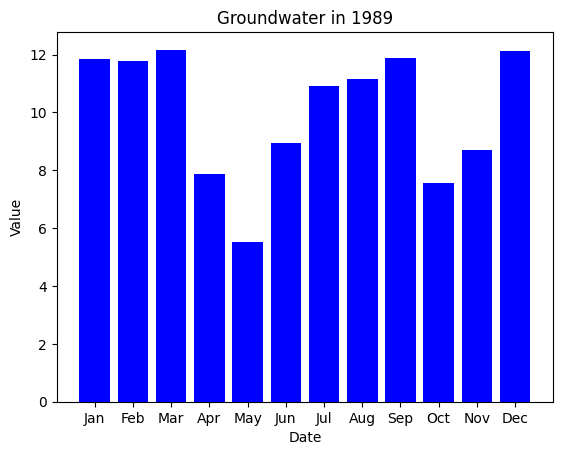

Range of data set 1: 1981-01-31 00:00:00 - 1981-02-14 00:00:00
Range of data set 2: 1981-02-15 00:00:00 - 1981-03-01 00:00:00


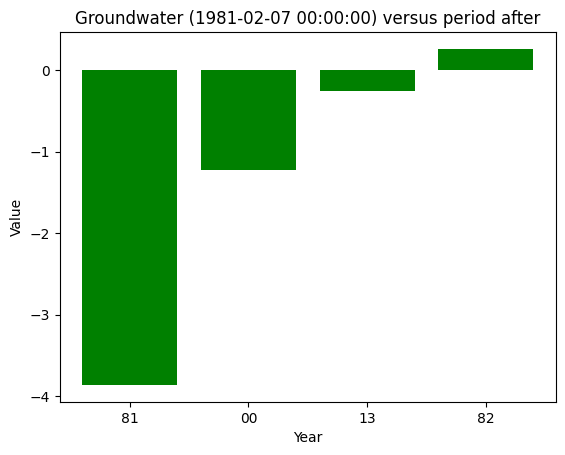

In [16]:
'''
Top sites for each state:
New York:
[583, 'Local number, St-40, near Brasher Falls NY', 1720]
[522, 'Local number, Og-23, near Hartwick NY', 1542]
[544, 'Local number, Ot-900, near Manchester NY', 1513]
[505, 'Local number, Sb-472, near Kanona NY', 1499]
[565, 'Local number, Ni-70, near Ransomville NY', 1458]
Vermont:
[13, 'VT-WBW  101', 5957]
[14, 'VT-WBW  102', 5935]
[1, 'VT-CKW    1', 660]
[0, 'VT-PQW    1', 656]
[15, 'VT-MPW    1', 649]
New Hampshire:
[2, 'NH-WCW 1  Warner, NH', 569]
[4, 'NH-SJW    2', 301]
[3, 'NH-ENW   30', 212]
[1, 'NH-PBW  148  Pembroke, NH', 127]
[0, 'NH-NBW 7 New Boston, NH', 2]
Connecticut:
[11, ' CT-GT    19', 2212]
[71, ' CT-NOC    7', 1124]
[66, ' CT-SY    23', 920]
[48, ' CT-MS    19', 915]
[70, ' CT-SY    24 SALISBURY, CT', 894]
Rhode Island:
[4, 'RI-SNW    6 SOUTH KINGSTOWN, RI', 1155]
[5, 'RI-RIW  417 RICHMOND, RI', 1139]
[3, 'RI-RIW  600 RICHMOND, RI', 1037]
[13, 'RI-EXW  475 EXETER, RI', 837]
[9, 'RI-NKW  255', 672]
Massechusetts:
[119, 'MA-GMW    2 GREAT BARRINGTON, MA', 1340]
[165, 'MA-HLW   23 HAVERHILL, MA', 1332]
[163, 'MA-NIW   27 NEWBURY, MA', 1328]
[150, 'MA-XMW   78 WILMINGTON, MA', 1307]
[90, 'MA-LKW   14 LAKEVILLE, MA', 1293, earliest, latest, median time between recordings]
Maine:
[2, 'ME-CW26 Brunswick, Maine', 1205]
[6, 'ME-KW766 Litchfield, Maine', 543]
[19, 'ME-ARW890 Fort Kent, Maine', 495]
[14, 'ME-WW796 Calais, Maine', 463]
[11, 'ME-WW797 Township T24MD BPP (Hadley Lakes)', 462]




datetime utils
stats
graph of for each year, average distance between each recording (weeks/months etc) for each station
gather percentiles for top ___ stations
    5%, 10%, etc
        period of record for each station
        return of percentile and value
print out median (50%tile)
see how percentiles vary throughout the year
'''
state = "MA"
start_date = "1981"
end_date = "2022"
year = "1989"
date = "02-07"
window_in_wks = 1

data = get_usgs_gw1(state, start_date, end_date)
#compare_to_mean(data, state, "2020", start_date, end_date, 13, True)
#gw_month_over_years(data, state, start_date, end_date, "Apr", 13, True)
gw_one_year(data, state, year, 119, True)
graph_comparison(data, date, start_date, end_date, 119, window_in_wks)


In [15]:
# graph comparison
import matplotlib.pyplot as plt
MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]

def sortkey(e):
    return e[1]

def graph_comparison(data, date, start_date, end_date, index_of_site, window):
    graph = show_site_data(data, index_of_site, False)
    if len(date) == 5:
        date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date + dt.timedelta(weeks=-1 * window)
        end = date + dt.timedelta(weeks=window)
        start2 = date + dt.timedelta(weeks=window,days=1)
        end2 = date + dt.timedelta(weeks=3 * window,days=1)
    else:
        start = dt.datetime(int(start_date), int(date), 1)
        end = dt.datetime(int(start_date), int(date), int(MONTH_DATA[int(date) - 1]))
        start2 = end + dt.timedelta(days=1)
        end2 = end + dt.timedelta(days= MONTH_DATA[int(date)] + 1)
    print(f'Range of data set 1: {start} - {end}\nRange of data set 2: {start2} - {end2}')
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    #for i in range(len(first_set)):
            #plottable.append([first_set[i][0], second_set[i][1] - first_set[i][1]])
    plottable.sort(key=sortkey)
    dct = {}
    for i in plottable:
        dct[(str(i[0]))[2:4]] = i[1]
    plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title("Groundwater (%s) versus period after" % (date))
    plt.show()
    

In [87]:
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''

def sortkey(e):
    return e[-2]

state = "VT"
start_date = "1900"
end_date = "2023"
stations = []
data = get_usgs_gw1(state, start_date, end_date)
for i in range(len(data["value"]["timeSeries"])):
    reps = num_of_reps(data, i)
    if reps > 999:
        differences = []
        for num in range(reps):
            if num + 1 < reps:
                value1 = get_gw_date(data, i, num)
                value2 = get_gw_date(data, i, num + 1)
                value3 = dt.datetime(int(value1[0:4]), int(value1[5:7]), int(value1[8:10]))
                value4 = dt.datetime(int(value2[0:4]), int(value2[5:7]), int(value2[8:10]))
                differences.append([value1, (value4 - value3).days])
        # calculate average duration between each input
        #print(differences)
        curr_category = ''
        category = ''
        temp_list = []
        category_lst = []
        start_d = ''
        for val in differences:
            if val[1] > 0 and val[1] < 4:
                category = 'daily'
            elif val[1] > 5 and val[1] < 10:
                category = 'weekly'
            elif val[1] > 25 and val[1] < 35:
                category = 'monthly'
            else:
                category = ''
            if curr_category == '':
                curr_category = category
                start_d = val[0]
            if category != curr_category:
                temp_list.append(category)
                if len(temp_list) == 3:
                    category_lst.append([start_d, val[0], curr_category])
                    curr_category = category
                    start_d = val[0]
                    temp_list = []
        print(category_lst)


        station = get_site(data, i)
        stations.append([i, station ,reps, get_gw_date(data, i, 0)])


        '''
        HERE'S THE PLAN:

        Check in 3 different categories:
        1-3 days (daily)
        5-10 days (weekly)
        25-35 days (monthly)

        if date falls into category, set curr_category to that
        if date doesnt fall into category, add to temp list
        if temp list reaches 3 long, set new category to what the temp list values are, keep going
        every time category changes, append start and end date of category to list
        if dates dont fall into category, skip over




        '''





    #print(f'({i} {get_site(data, i)} ----> {num_of_reps(data, i)}')
stations.sort(reverse = True, key=sortkey)
for i in stations:
    print(i)




[['1992-11-24', '1993-06-10', 'daily'], ['1993-07-12', '1993-08-25', 'weekly'], ['1993-10-12', '1993-10-21', 'weekly'], ['1993-10-21', '1996-09-03', 'daily'], ['1996-10-11', '1999-12-21', 'daily'], ['1999-12-21', '2000-01-05', 'weekly'], ['2000-01-05', '2001-11-26', 'daily'], ['2001-11-26', '2001-12-18', 'weekly'], ['2001-12-18', '2004-01-06', 'daily'], ['2004-01-06', '2004-05-10', 'monthly'], ['2004-05-10', '2010-02-02', 'daily'], ['2010-02-02', '2010-08-03', 'monthly'], ['2010-10-05', '2011-11-01', 'monthly'], ['2011-12-07', '2013-07-02', 'monthly'], ['2013-08-06', '2014-09-01', 'monthly'], ['2014-10-06', '2016-03-03', 'monthly'], ['2016-04-08', '2017-07-31', 'monthly'], ['2017-09-04', '2019-12-04', 'monthly'], ['2020-01-08', '2021-06-02', 'monthly'], ['2021-07-07', '2023-03-03', 'monthly'], ['2023-06-05', '2023-10-04', 'monthly']]
[['1992-11-24', '1993-06-10', 'daily'], ['1993-07-12', '1993-08-25', 'weekly'], ['1993-10-12', '1993-10-21', 'weekly'], ['1993-10-21', '1996-09-01', 'dail